### Introduction

The HEOM method solves the dynamics and steady state of a system and its environment, the latter of which is encoded in a set of auxiliary density matrices.

In this example we show the evolution of a single two-level system in contact with a single Bosonic environment.  The properties of the system are encoded in Hamiltonian, and a coupling operator which describes how it is coupled to the environment.

The Bosonic environment is implicitly assumed to obey a particular Hamiltonian (see paper), the parameters of which are encoded in the spectral density, and subsequently the free-bath correlation functions.

In the example below we show how to model the overdamped Drude-Lorentz Spectral Density, commonly used with the HEOM. We show how to do the Matsubara and Pade analytical decompositions, as well as how to fit the latter with a finite set of approximate exponentials.  

### Drude-Lorentz spectral density
The Drude-Lorentz spectral density is:

$$J(\omega)=\omega \frac{2\lambda\gamma}{{\gamma}^2 + \omega^2}$$

where $\lambda$ scales the coupling strength, and $\gamma$ is the cut-off frequency.

With the HEOM we must use an exponential decomposition:

\begin{equation*}
C(t)=\sum_{k=0}^{k=\infty} c_k e^{-\nu_k t}
\end{equation*}

The Matsubara decomposition of the Drude-Lorentz spectral density is given by:

\begin{equation*}
    \nu_k = \begin{cases}
               \gamma               & k = 0\\
               {2 \pi k} / {\beta \hbar}  & k \geq 1\\
           \end{cases}
\end{equation*}

\begin{equation*}
    c_k = \begin{cases}
               \lambda \gamma (\cot(\beta \gamma / 2) - i) / \hbar               & k = 0\\
               4 \lambda \gamma \nu_k / \{(nu_k^2 - \gamma^2)\beta \hbar^2 \}    & k \geq 1\\
           \end{cases}
\end{equation*}



In [1]:
%pylab inline
from qutip import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip.ipynbtools import HTMLProgressBar

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from heom_fmotd import BosonicHEOMSolver

In [5]:
# Defining the system Hamiltonian
eps = 0.0     # Energy of the 2-level system.
Del = .2    # Tunnelling term
Hsys = 0.5 * eps * sigmaz() + 0.5 * Del* sigmax()

In [6]:
# System-bath coupling (Drude-Lorentz spectral density)
Q = sigmaz() # coupling operator

#Bath properties:
gamma = 1. # cut off frequency
lam = 2.5 # coupling strenght
T = 1.0 # in units where Boltzmann factor is 1

#HEOM parameters
Nk = 2 # number of exponentials in approximation of the the spectral density
NC = 30 # cut off parameter for the bath

Text(0, 0.5, 'J')

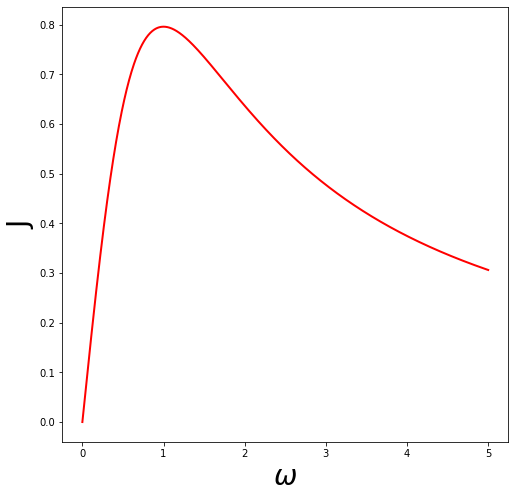

In [7]:
###############################################

# defines cks and vks for the Matsubara decomposition of the Drude Lorentz spectral density


def cot(x):
    return 1./np.tan(x)

wlist = np.linspace(0, 5, 1000)
pref = 1.

J = [w * 2 * lam * gamma / (np.pi*(gamma**2 + w**2)) for w in wlist]

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
axes.plot(wlist, J, 'r', linewidth=2)
axes.set_xlabel(r'$\omega$', fontsize=28)
axes.set_ylabel(r'J', fontsize=28)



In [41]:

def c(t):
    c_temp =[]
    c_temp.append(pref * lam * gamma * (-1.0j + cot(gamma / (2 * T))) * np.exp(-gamma * t))
    for k in range(1,100):
        vk = 2 * np.pi * k * T
        c_temp.append((pref * 4 * lam * gamma * T * vk / (vk**2 - gamma**2))  * np.exp(- vk * t) ) 
    return c_temp

ckAR = [pref * lam * gamma * (cot(gamma / (2 * T))) + 0.j]
ckAR.extend([(pref * 4 * lam * gamma * T *  2 * np.pi * k * T / (( 2 * np.pi * k * T)**2 - gamma**2))+0.j for k in range(1,Nk)])

vkAR = [gamma+0.j]
vkAR.extend([2 * np.pi * k * T + 0.j for k in range(1,Nk)])

ckAI= [pref * lam * gamma * (-1.0) + 0.j]

vkAI = [gamma+0.j]

print(ckAR)
print(ckAI)

print(vkAR)
print(vkAI)




[(4.57621930428113+0j), (1.6329115640316914+0j)]
[(-2.5+0j)]
[(1+0j), (6.283185307179586+0j)]
[(1+0j)]


In [42]:
def Jw(w):
    Jt  = w * 2 * lam * gam/ ((gam**2 + w**2)) 
    return Jt

from spectra import bath_correlation
tlist = np.linspace(0,10,1000)

# plt.plot(tlist, y)
# plt.show()

print("Computing bath correlation function.")

corrRnum, corrInum = bath_correlation(tlist, Jw, T, wstart=0, wend=100)
print("Got bath correlation function.")

Computing bath correlation function.


NameError: name 'gam' is not defined

Text(0, 0.5, 'Re[C(t)]')

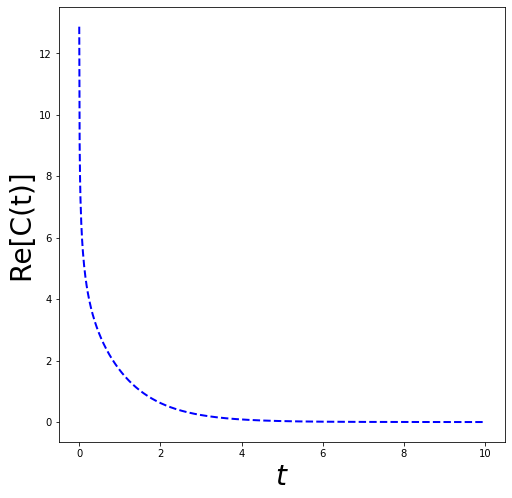

In [43]:
# Reals parts
corrRana = [np.real(sum(c(t))) for t in tlist]
# Imaginary parts
corrIana = [np.imag(sum(c(t))) for t in tlist]

# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(tlist, corrInum, 'r', linewidth=2)
axes.plot(tlist, corrRana, 'b--', linewidth=2)
axes.set_xlabel(r'$t$', fontsize=28)
axes.set_ylabel(r'Re[C(t)]', fontsize=28)


In [44]:

NR = len(ckAR)
NI = len(ckAI)
Q2 = [Q for kk in range(NR+NI)]
print(Q2)
options = Options(nsteps=15000, store_states=True, rtol=1e-14, atol=1e-14)

resultNew = BosonicHEOMSolver(Hsys, Q2, ckAR, ckAI, vkAR, vkAI, NC, options=options)

[Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]], Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]]
SIMPL DUN
making python csr matrix


In [45]:
# Initial state of the system.
rho0 = basis(2,0) * basis(2,0).dag()   
# Times to record state
tlist = np.linspace(0, pi/Del, 600)

result = resultNew.run(rho0, tlist)


In [46]:
# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p=basis(2,0) * basis(2,0).dag()
P22p=basis(2,1) * basis(2,1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p=basis(2,0) * basis(2,1).dag()
# Calculate expectation values in the bases
P11exp = expect(result.states, P11p)
P22exp = expect(result.states, P22p)
P12exp = expect(result.states, P12p)

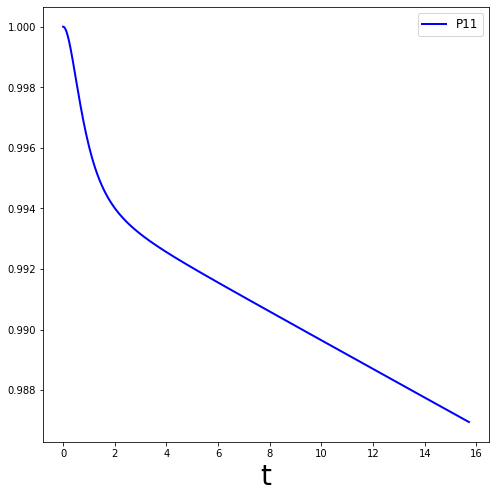

In [47]:
# Plot the results
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8,8))
#axes.plot(tlist, np.real(P11exp)+ np.real(P22exp), 'b', linewidth=2, label="P11")
axes.plot(tlist, np.real(P11exp), 'b', linewidth=2, label="P11")
#axes.plot(tlist, np.real(P12exp), 'r', linewidth=2, label="P12")
axes.set_xlabel(r't', fontsize=28)
axes.legend(loc=0, fontsize=12)

In [19]:
def _calc_matsubara_params():
        """
        Calculate the Matsubara coefficents and frequencies
        Returns
        -------
        c, nu: both list(float)
        """
        c = []
        nu = []
        lam0 = lam
        gam = gamma
        hbar = 1
        beta = 1.0/(temperature)
        N_m =  Nk

        g = 2*np.pi / (beta)
        for k in range(N_m):
            if k == 0:
                nu.append(gam)
                c.append(lam0*gam*
                    (1.0/np.tan(gam*hbar*beta/2.0) - 1j) / hbar)
            else:
                nu.append(k*g)
                c.append(4*lam0*gam*nu[k] /
                      ((nu[k]**2 - gam**2)*beta*hbar**2))

    
        return c, nu

ctest,nutest=_calc_matsubara_params()

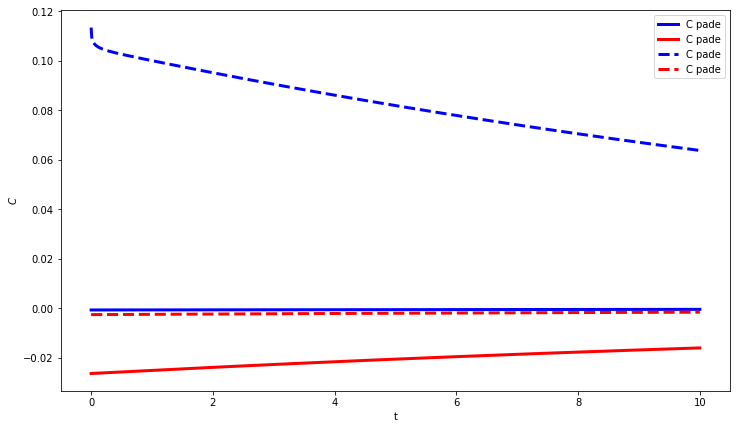

In [65]:
#as a comparison, this is matsubara

tlist = np.linspace(0,10,1000)
#lmax = 1000000
#lmax = 1000000
lmax = 2
kappa = [0.]
kappa.extend([1. for l in range(1,lmax+1)])
epsilon = [0]
epsilon.extend([(2*l-1)*pi for l in range(1,lmax+1)])
beta = 1/T

def f(x):
    kB=1.
    return 1/(exp(x)-1.)


def C(tlist):
    eta_list = []
    gamma_list  =[]
    
    #l = 0
    eta_0 = 0.5*lam*gamma*f(1.0j*beta*gamma)
    gamma_0 = gamma
    eta_list.append(eta_0)
    gamma_list.append(gamma_0)
    if lmax>0:
        for l in range(1,lmax+1):
            eta_list.append(-1.0j*(kappa[l]/beta)*lam*gamma**2/(-(epsilon[l]**2/beta**2)+gamma**2))
            gamma_list.append(epsilon[l]/beta)
    c_tot = []
    for t in tlist:
        c_tot.append(sum([eta_list[l]*exp(-gamma_list[l]*t) for l in range(lmax+1)]))
    return c_tot, eta_list, gamma_list


cppL,etapL,gampL = C(tlist)

fig, ax1 = plt.subplots(figsize=(12, 7))
#print(gam_list)
ax1.plot(tlist,real(cppL), color="b", linewidth=3, label= r"C pade")
ax1.plot(tlist,imag(cppL), color="r", linewidth=3, label= r"C pade")
ax1.plot(tlist,corrRana, "b--", linewidth=3, label= r"C pade")
ax1.plot(tlist,corrIana, "r--", linewidth=3, label= r"C pade")


ax1.set_xlabel("t")
ax1.set_ylabel(r"$C$")
ax1.legend()


### try underdamped case

In [344]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.5.0.dev0
Numpy,1.15.4
SciPy,1.1.0
matplotlib,3.1.1
Cython,0.29.14
Number of CPUs,6
BLAS Info,INTEL MKL
IPython,7.10.2
Python,"3.7.5 (default, Oct 25 2019, 15:51:11) [GCC 7.3.0]"
OS,posix [linux]


nc: 10
SIMPL DUN
SIMPL DUN
MUCH BEFORE
[]
[]
[]
[]
[0.010003126465607108, 0.010003126465607108j, 0.010003126465607108, (-0-0.010003126465607108j)]
[(0.025-0.9996874511566103j), (0.025-0.9996874511566103j), (0.025+0.9996874511566103j), (0.025+0.9996874511566103j)]
making python csr matrix
starting solve


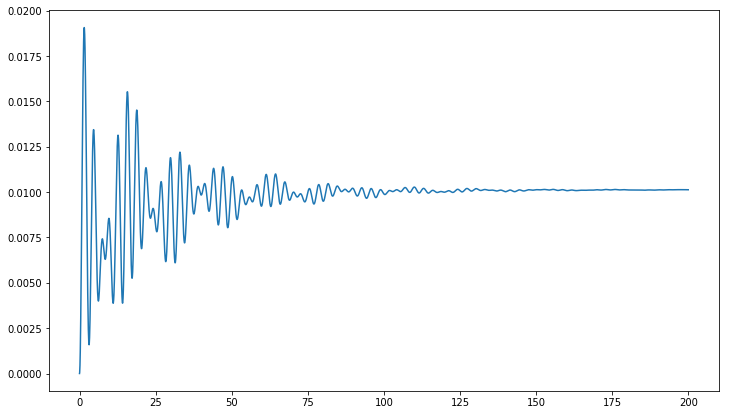

In [37]:

gamma = 0.05
w0=1.0


lam =0.2
Gamma = gamma/2.
Om = np.sqrt(w0**2 - Gamma**2)
factor=1./4.
ckAR= [factor*lam**2/(Om),factor*lam**2/(Om)]
#note:  the frequencies here are NEGATIVE from their nomral def
vkAR= [-(1.0j*Om - Gamma),-(-1.0j*Om - Gamma)]

ckAI =[-factor*lam**2*1.0j/(Om),factor*lam**2*1.0j/(Om)]
#ckAI =[factor*lam**2*1.0j/(Om),-factor*lam**2*1.0j/(Om)]

#vkAI = [-(-1.0j*(Om) - Gamma-1e-3),-(1.0j*(Om) - Gamma-1e-3)]
vkAI = [-(-1.0j*(Om) - Gamma),-(1.0j*(Om) - Gamma)]





NR=2
NI=2
# Q = sigmax()
Q = [sigmax(), sigmax(), sigmax(), sigmax()]
Del = 0.#np.pi/2.    
wq = 1.0     # Energy of the 2-level system.
Hsys = 0.5 * wq * sigmaz() + 0.5 * Del * sigmax()
# Hsys = 1

#tlist = np.linspace(0, 7.777777777777778, 36)
tlist = np.linspace(0, 200, 4000)
    
#for amirs Omega= pi data, tlist is different (actually a bit weird)
#tlist=tlistA
initial_state = basis(2,1) * basis(2,1).dag()                # Initial state of the system.


#return_vals = [tensor(qeye(N), kk) for kk in [Q]]            # List for which to calculate expectation value
return_vals = [initial_state, basis(2,0) * basis(2,1).dag()   ]            # List for which to calculate expectation value
eigen_sparse = False
calc_time = True                                             
options = Options(nsteps=15000, store_states=True,rtol=1e-12, atol=1e-12)        # Options for the solver.


#Convergence parameters
#we need very high Nc to get convergence.  might be interesting to understand why
Nc = input("nc: ")
Nc = int(Nc)

# results1Nc7 = a.hsolve(Hsys, Q,ckAR,ckAI,vkAR,vkAI, Nc, NR,NI, tlist, initial_state, options=options,\
    # progress_bar1=TextProgressBar(),progress_bar2=TextProgressBar())

# print("here")
# note that this expects the cks and vks as lists and not numpy arrays
# Hsys = liouvillian(Hsys)
def func(x):
    return 0.0*cos(x)
#Hsys = [Hsys, [sigmax(), func]]
#Hsys = Hsys
#L = liouvillian(Hsys,[])
A = BosonicHEOMSolver(Hsys, Q,ckAR,ckAI,vkAR,vkAI, Nc, options=options)
print("starting solve")
B, blerg= A.run(initial_state, tlist)

fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.plot(tlist,expect(B.states,1-initial_state*initial_state.dag()))

